## Solving the Heat Equation with Forward Euler and Feed-Forward Neural Network

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## Forward Euler Scheme

In [3]:
def diffusion_solver(I, alpha=1, L=1, Nx=11, T=1, F=0.5, udim='1D'):
    """
    Solver for 1D diffusion equations with constant diffusion coefficent and
    no source term:
                            u_t = a*u_xx
    on spatial domain (0,L) and temporal domain [0, T].

    Parameters
    ----------
    I : Initial condition, I(x), as callable object (i.e. a function)
    alpha : Diffusion coefficient
    L : Length of the spatial domain ([0,L])
    Nx : Number of mesh cells; mesh points are numbered from 0 to Nx
    T : Simulation (stop) time
    F : The dimensionless number a*dt/dx**2; implicitly specifies the time step
    udim : '1D' or '2D' solution array as output
    """

    assert alpha > 0, f'Diffusion coefficient alpha must be greater than 0'
    assert F <= 0.5, \
        f'Stability criterion F=alpha*dt/dx**2 <= 0.5 not satisfied with F={F}'
    x = np.linspace(0, L, Nx + 1)       # mesh points in space
    dx = x[1] - x[0]                    # constant mesh spacing in x
    dt = F * dx**2 / alpha              # constant mesh spacing in t
    Nt = int(T / dt)
    t = np.linspace(0, T, Nt + 1)        # mesh points in time
    u_arr = np.zeros((Nt + 1, Nx + 1))   # 2D solution array
    u = np.zeros(Nx + 1)                 # 1D solution array
    u1 = I(x)                            # initial condition
    u1[0] = u1[Nx] = 0.0                 # boundary conditions
    u_arr[0] = u1

    for n in range(0, Nt):
        # Update all inner points
        u[1:Nx] = u1[1:Nx] + F * (u1[0:Nx - 1] - 2 * u1[1:Nx] + u1[2:Nx + 1])
        # Boundary conditions
        u[0] = 0.0
        u[Nx] = 0.0
        u_arr[n] = u
        # Update u1 before next step
        u1, u = u, u1  # just switch references

    if udim == '2D':
        return u_arr, x, t
    else:
        return u, x, t

    
def I(x):
    """
    Initial condition
    """

    return np.sin(np.pi * x)


def u_exact(x, t):
    """
    Analytic solution
    """

    return np.sin(np.pi * x) * np.exp(-np.pi**2 * t)    

Max diff: 0.04009472326320718
Mean diff: 0.0031862888535143666


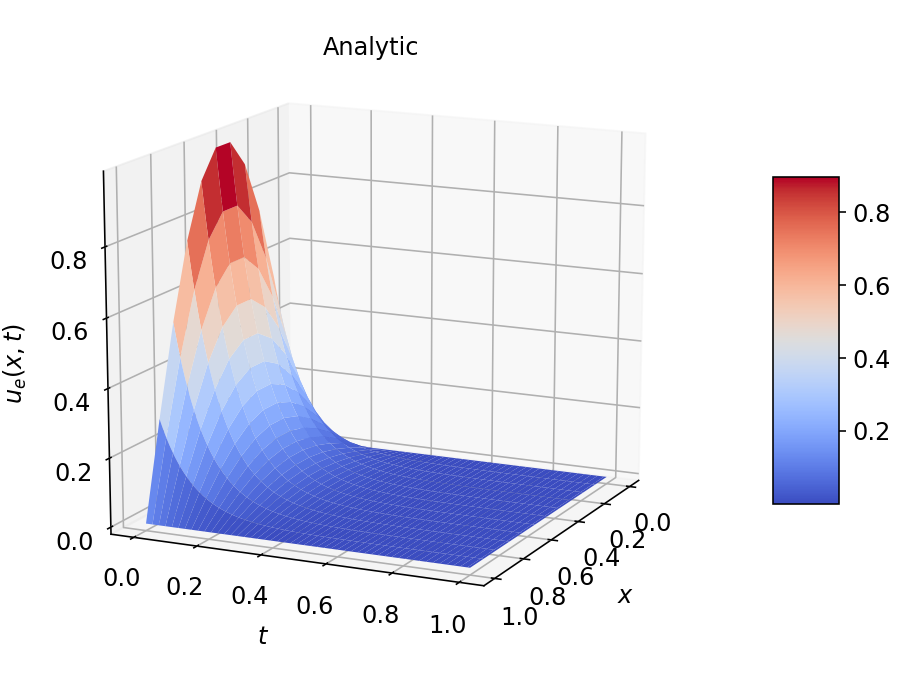

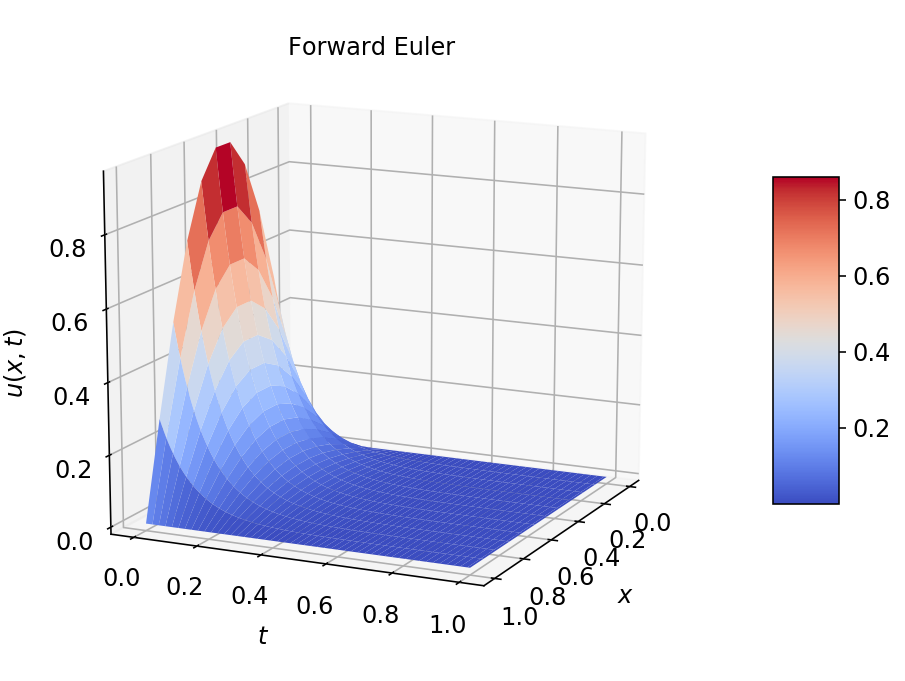

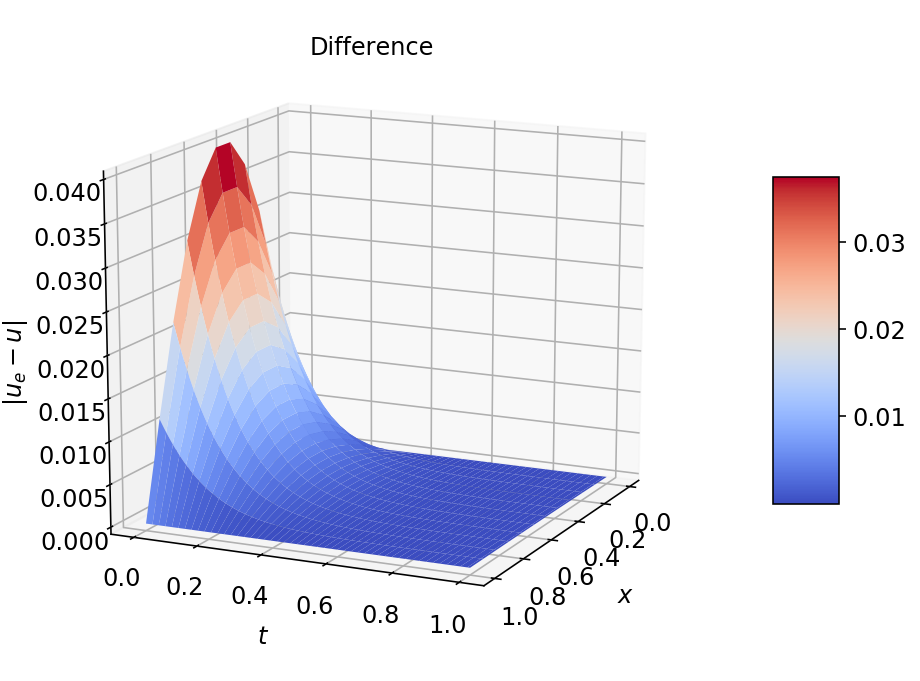

In [4]:
u, x, t = diffusion_solver(I, alpha=1, L=1, Nx=11, T=1, F=0.5, udim='2D')
x, t = np.meshgrid(x, t)
ue = u_exact(x, t)

diff = np.abs(ue - u)
print(f"Max diff: {np.max(diff)}")
print(f"Mean diff: {np.mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(x, t, ue, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u_e(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana_fe.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Forward Euler")
surf = ax.plot_surface(x, t, u, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_fe.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(x, t, diff, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$|u_e - u|$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_fe.pdf"), bbox_inches='tight')

plt.show()

## Benchmark CPU time

In [5]:
num_iter = 1000     # number of iterations
times_fe = []

for i in range(num_iter):
    start_time_fe = time.perf_counter()
    diffusion_solver(I, alpha=1, L=1, Nx=11, T=1, F=0.5, udim='2D')
    end_time_fe = time.perf_counter()
    run_time_fe = end_time_fe - start_time_fe
    times_fe.append(run_time_fe)

print(f'Number of iterations: {num_iter}')    
print(f'FE mean CPU time: {np.mean(times_fe):.5f} secs')    

Number of iterations: 1000
FE mean CPU time: 0.00122 secs


## Feed-Forward Neural Network

In [6]:
def g_analytic(x, t):
    """
    Analytic solution
    """

    return tf.sin(np.pi * x) * tf.exp(-np.pi**2 * t)

## First model: Train on spatial and temporal points as dictated by FE stability criterion

In [7]:
tf.random.set_seed(42)

# Define grid
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(1, dtype=tf.float64)

Nx = 11
x_lin = tf.linspace(start, stop, Nx)
dx = x_lin[1] - x_lin[0]
dt = 0.5 * dx * dx
Nt = int(stop/dt)
print('Number of time points:', Nt)
t_lin = tf.linspace(start, stop, Nt)
X, T = tf.meshgrid(x_lin, t_lin)

x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])


class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(150, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(1, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)

        return self.out(x)


@tf.function
def IC(x):
    """
    Initial condition
    """

    return tf.sin(np.pi * x)


@tf.function
def trial_solution(model, x, t):
    """
    Trial solution
    """

    points = tf.concat([x, t], axis=1)
    return (1 - t) * IC(x) + x * (1 - x) * t * model(points)


@tf.function
def loss(model, x, t):
    """
    Loss/cost function
    """

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        with tf.GradientTape(persistent=True) as tape_2:
            tape_2.watch([x, t])

            trial = trial_solution(model, x, t)

        d_trial_dx = tape_2.gradient(trial, x)
        d_trial_dt = tape_2.gradient(trial, t)

    d2_trial_d2x = tape.gradient(d_trial_dx, x)

    del tape_2
    del tape

    return tf.losses.MSE(tf.zeros_like(d2_trial_d2x), d2_trial_d2x - d_trial_dt)


# Define gradient method
@tf.function
def grad(model, x, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, t)

    return loss_value, tape.gradient(loss_value, model.trainable_variables)


# Initial model and optimizer
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)

# Run training loop
num_epochs = 1000

start_time_nn = time.perf_counter()
for epoch in range(num_epochs):
    # Apply gradients in optimizer
    cost, gradients = grad(model, x, t)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Output loss improvement
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

end_time_nn = time.perf_counter()
run_time_nn = end_time_nn - start_time_nn
print(f'FFNN CPU time: {run_time_nn:.5f} secs')

Number of time points: 199
Step: 1, Loss: 11.031533869301281
Step: 100, Loss: 1.0610233104718683
Step: 200, Loss: 0.1337882671733267
Step: 300, Loss: 0.05123035677908458
Step: 400, Loss: 0.024996990742717336
Step: 500, Loss: 0.01495714347189358
Step: 600, Loss: 0.018610909497685638
Step: 700, Loss: 0.0060900715622405795
Step: 800, Loss: 0.0043646677010790065
Step: 900, Loss: 0.003245213290883878
Step: 1000, Loss: 0.008364625976730513
FFNN CPU time: 19.14199 secs


### Plot solution on the grid FFNN is trained on

Max diff: 0.008950046440956521
Mean diff: 0.0031734773969917204


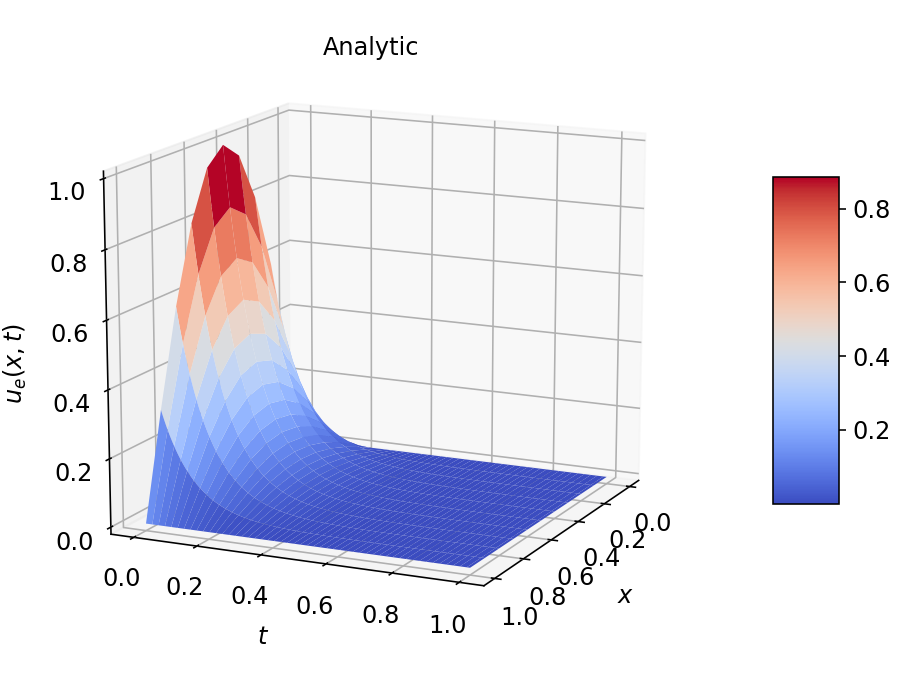

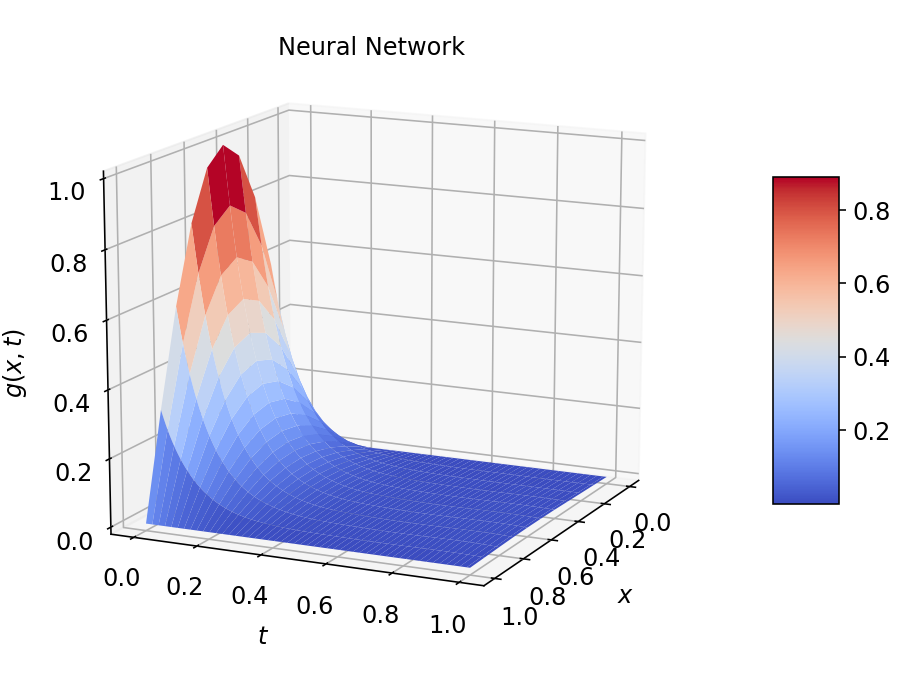

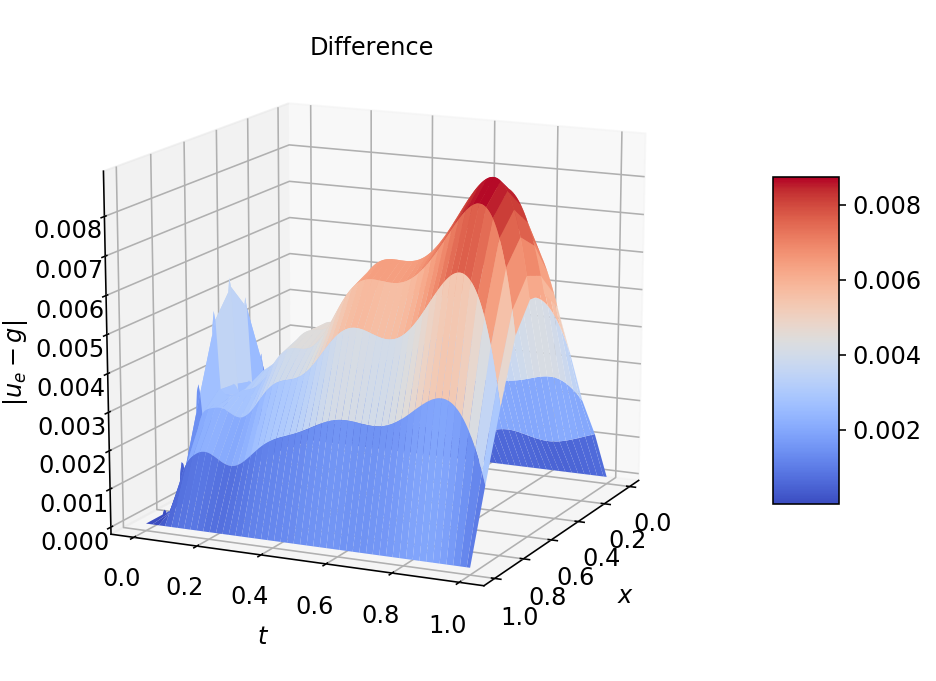

In [8]:
# Plot solution
g = tf.reshape(g_analytic(x, t), (Nt, Nx))
g_nn = tf.reshape(trial_solution(model, x, t), (Nt, Nx))

diff = tf.abs(g - g_nn)
print(f"Max diff: {tf.reduce_max(diff)}")
print(f"Mean diff: {tf.reduce_mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u_e(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana_nn1.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Neural Network")
surf = ax.plot_surface(X, T, g_nn, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$g(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_nn1.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(X, T, diff, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$|u_e - g|$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_nn1.pdf"), bbox_inches='tight')

plt.show()

### Plot solution on a larger grid than FFNN is trained on, i.e., points must be interpolated

Max diff: 0.008950808627230444
Mean diff: 0.0035110616053229456


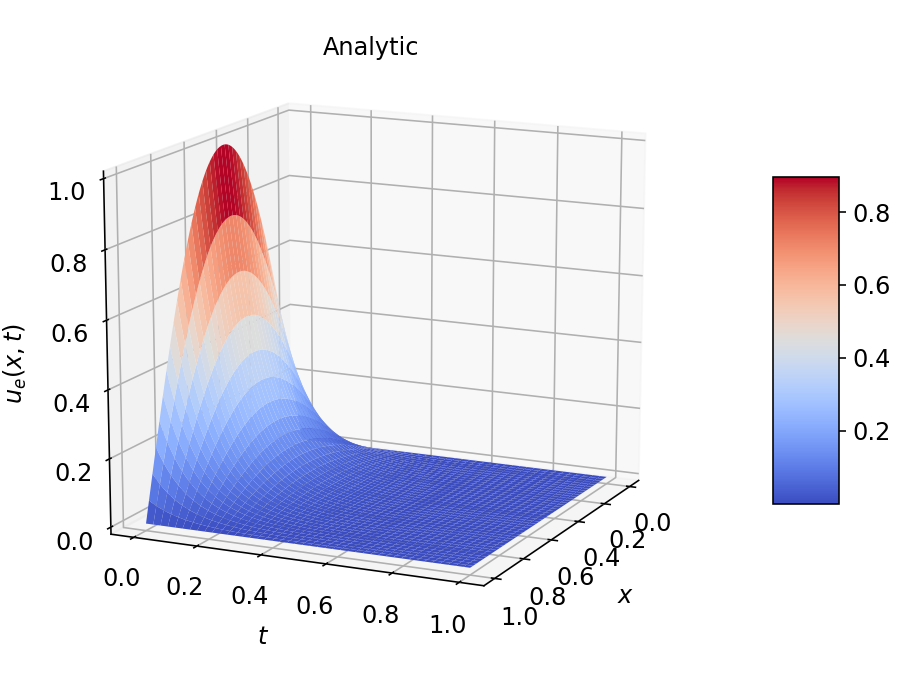

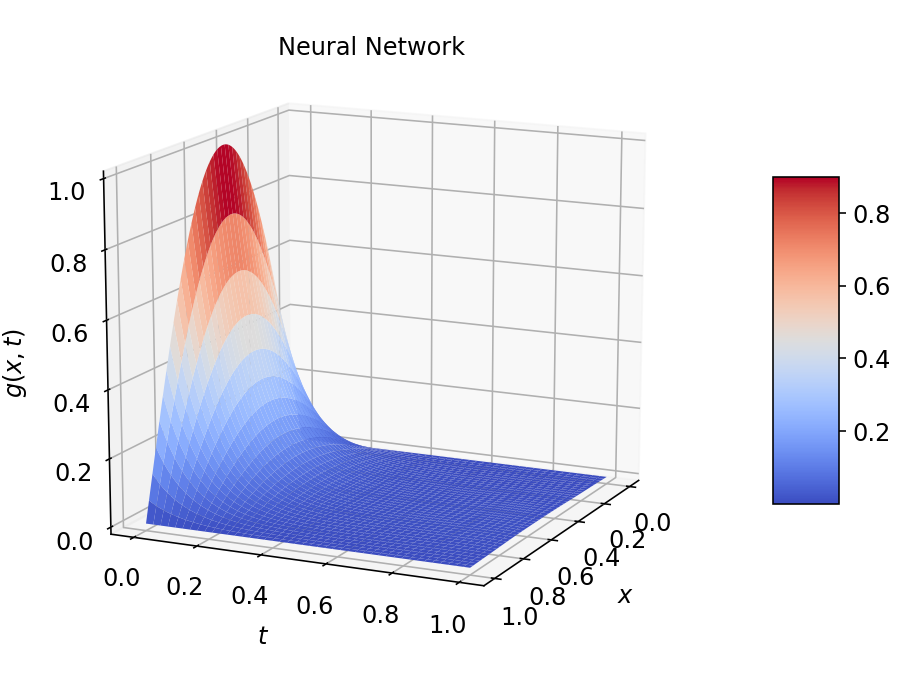

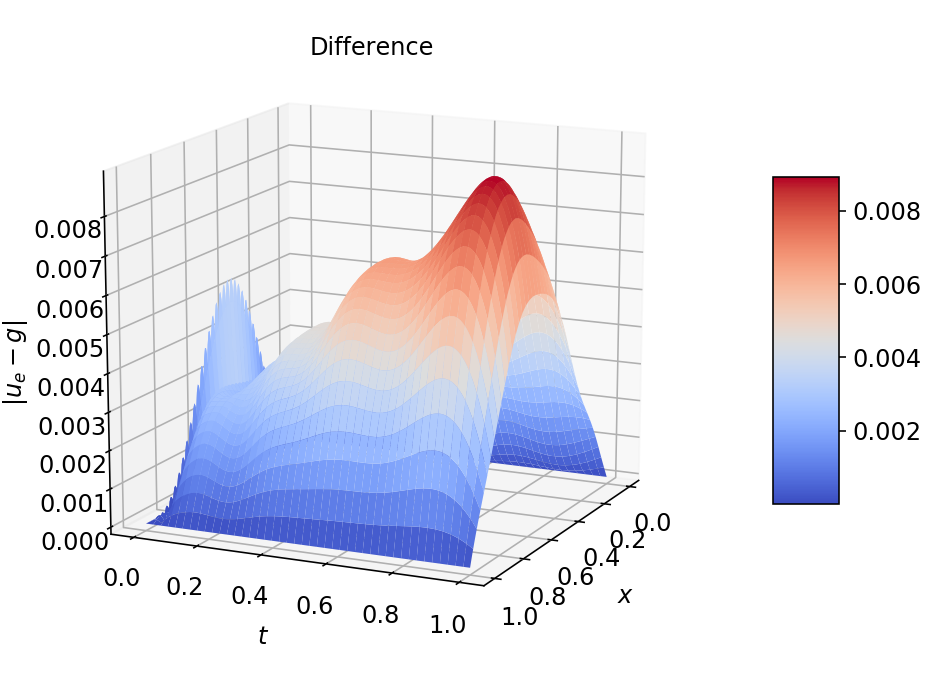

In [9]:
# Plot solution on larger grid
num_points = 301
X, T = tf.meshgrid(tf.linspace(start, stop, num_points), tf.linspace(start, stop, num_points))
x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])

g = tf.reshape(g_analytic(x, t), (num_points, num_points))
g_nn = tf.reshape(trial_solution(model, x, t), (num_points, num_points))

diff = tf.abs(g - g_nn)
print(f"Max diff: {tf.reduce_max(diff)}")
print(f"Mean diff: {tf.reduce_mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u_e(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana_nn2.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Neural Network")
surf = ax.plot_surface(X, T, g_nn, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$g(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_nn2.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(X, T, diff, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$|u_e - g|$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_nn2.pdf"), bbox_inches='tight')

plt.show()

## Second model: Train on equal number of spatial and temporal points

In [10]:
tf.random.set_seed(42)

# Define grid
num_points = 11
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(1, dtype=tf.float64)

X, T = tf.meshgrid(tf.linspace(start, stop, num_points), tf.linspace(start, stop, num_points))

x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])


class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(150, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(1, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)

        return self.out(x)


@tf.function
def IC(x):
    """
    Initial condition
    """

    return tf.sin(np.pi * x)


@tf.function
def trial_solution(model, x, t):
    """
    Trial solution
    """

    points = tf.concat([x, t], axis=1)

    return (1 - t) * IC(x) + x * (1 - x) * t * model(points)


@tf.function
def loss(model, x, t):
    """
    Loss/cost function
    """

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        with tf.GradientTape(persistent=True) as tape_2:
            tape_2.watch([x, t])

            trial = trial_solution(model, x, t)

        d_trial_dx = tape_2.gradient(trial, x)
        d_trial_dt = tape_2.gradient(trial, t)

    d2_trial_d2x = tape.gradient(d_trial_dx, x)

    del tape_2
    del tape

    return tf.losses.MSE(tf.zeros_like(d2_trial_d2x), d2_trial_d2x - d_trial_dt)


# Define gradient method
@tf.function
def grad(model, x, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, t)

    return loss_value, tape.gradient(loss_value, model.trainable_variables)


# Initial model and optimizer
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)

# Run training loop
num_epochs = 1000

start_time_nn = time.perf_counter()
for epoch in range(num_epochs):
    # Apply gradients in optimizer
    cost, gradients = grad(model, x, t)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Output loss improvement
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

end_time_nn = time.perf_counter()
run_time_nn = end_time_nn - start_time_nn
print(f'FFNN CPU time: {run_time_nn:.5f} secs')  

Step: 1, Loss: 11.709827018665527
Step: 100, Loss: 1.7191570831440603
Step: 200, Loss: 0.19827531159411788
Step: 300, Loss: 0.026092592036385545
Step: 400, Loss: 0.006777169695174291
Step: 500, Loss: 0.008584353293624484
Step: 600, Loss: 0.00727225127450905
Step: 700, Loss: 0.002940164849392617
Step: 800, Loss: 0.0025648573251315274
Step: 900, Loss: 0.002323731627827328
Step: 1000, Loss: 0.0027706372028779027
FFNN CPU time: 4.89815 secs


### Plot solution on the grid FFNN is trained on

Max diff: 0.026960526345021663
Mean diff: 0.0029853552164713893


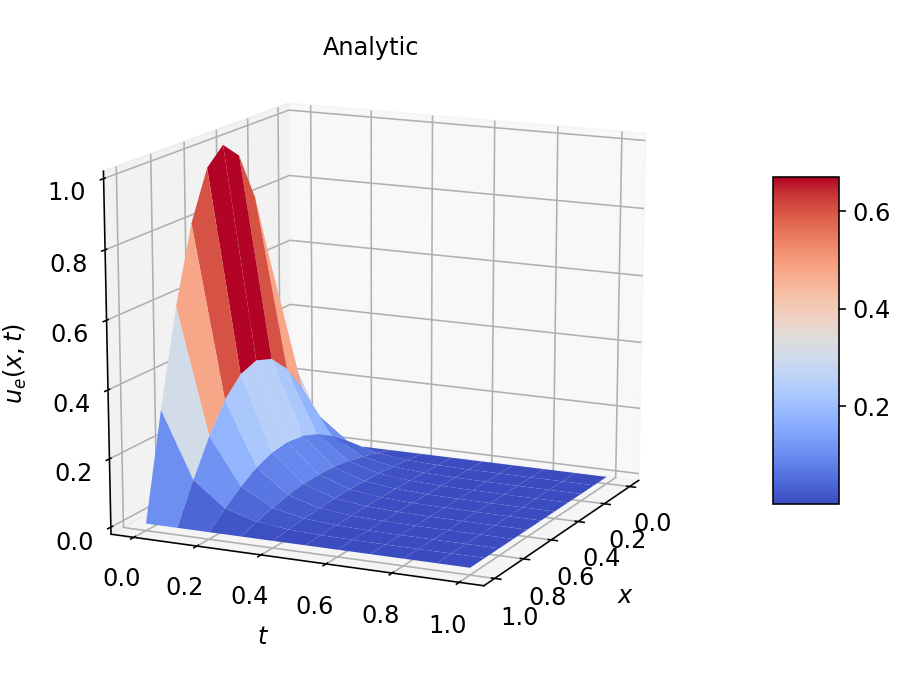

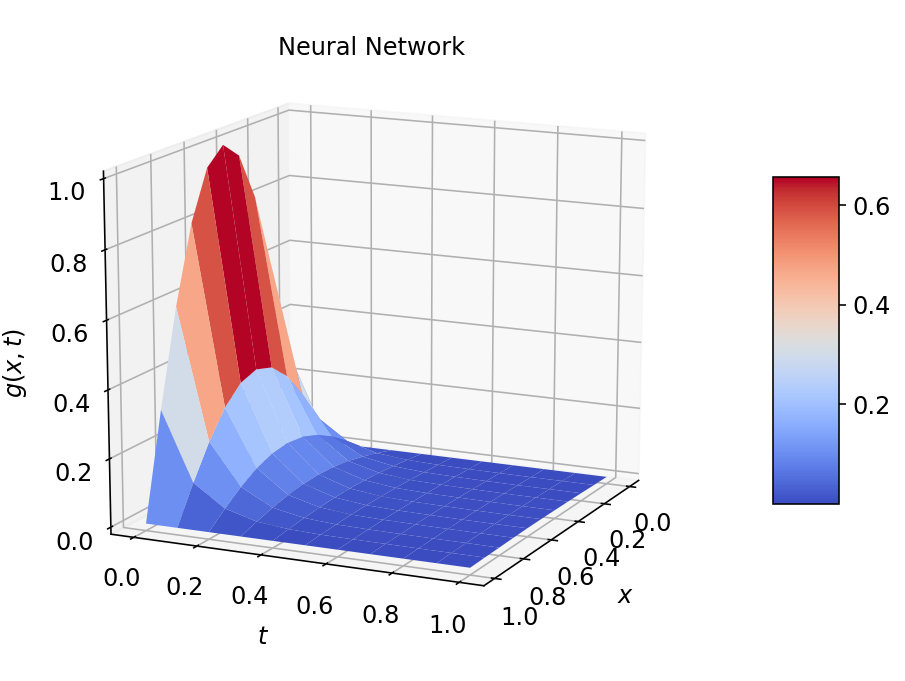

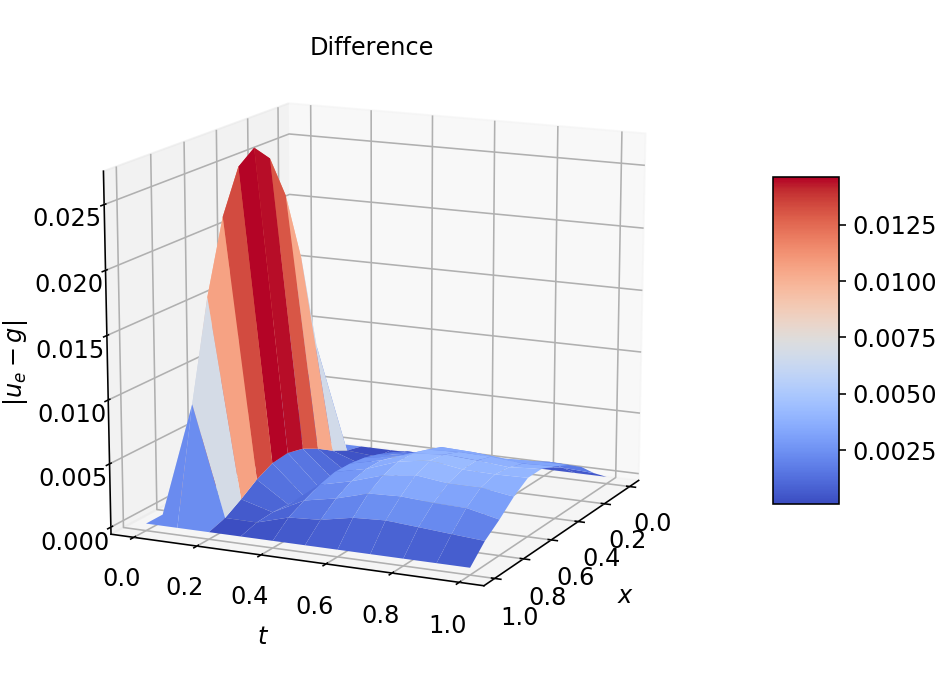

In [11]:
# Plot solution on larger grid
num_points = 11
X, T = tf.meshgrid(tf.linspace(start, stop, num_points), tf.linspace(start, stop, num_points))
x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])

g = tf.reshape(g_analytic(x, t), (num_points, num_points))
g_nn = tf.reshape(trial_solution(model, x, t), (num_points, num_points))

diff = tf.abs(g - g_nn)
print(f"Max diff: {tf.reduce_max(diff)}")
print(f"Mean diff: {tf.reduce_mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u_e(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana_nn3.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Neural Network")
surf = ax.plot_surface(X, T, g_nn, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$g(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_nn3.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(X, T, diff, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$|u_e - g|$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_nn3.pdf"), bbox_inches='tight')

plt.show()  

### Plot solution on a larger grid than FFNN is trained on, i.e., points must be interpolated

Max diff: 0.03215247426990031
Mean diff: 0.003951004410353005


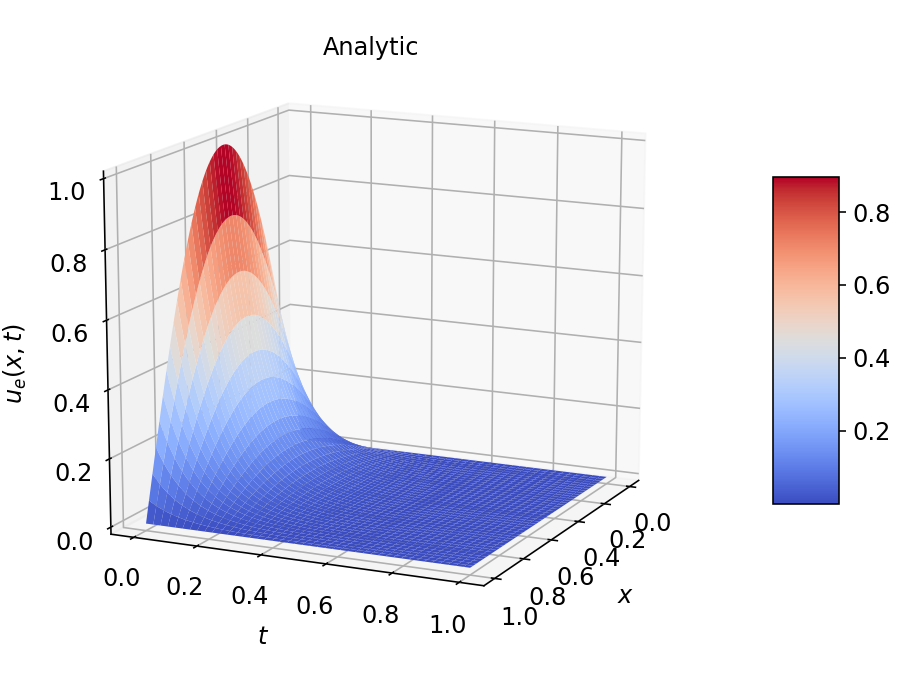

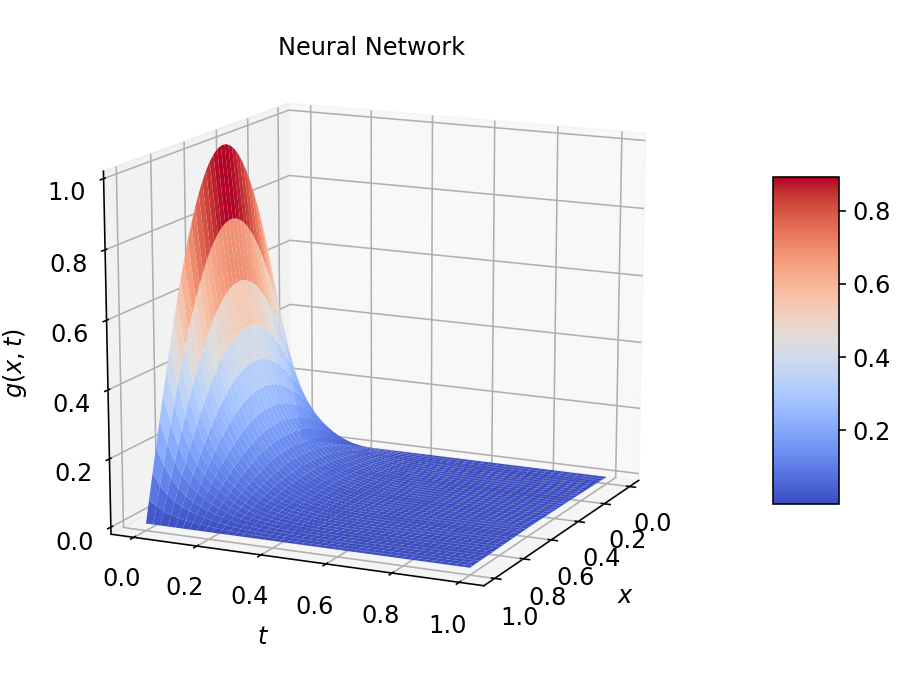

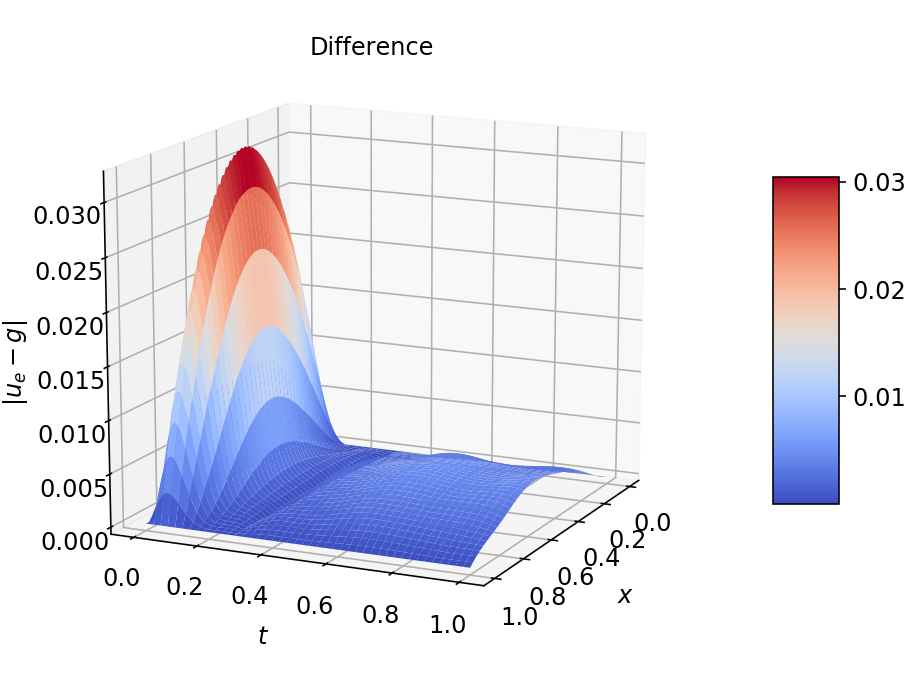

In [12]:
# Plot solution on larger grid
num_points = 301
X, T = tf.meshgrid(tf.linspace(start, stop, num_points), tf.linspace(start, stop, num_points))
x, t = tf.reshape(X, [-1, 1]), tf.reshape(T, [-1, 1])

g = tf.reshape(g_analytic(x, t), (num_points, num_points))
g_nn = tf.reshape(trial_solution(model, x, t), (num_points, num_points))

diff = tf.abs(g - g_nn)
print(f"Max diff: {tf.reduce_max(diff)}")
print(f"Mean diff: {tf.reduce_mean(diff)}")

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Analytic")
surf = ax.plot_surface(X, T, g, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$u_e(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_ana_nn4.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Neural Network")
surf = ax.plot_surface(X, T, g_nn, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$g(x,t)$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_nn4.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
ax.set_title("Difference")
surf = ax.plot_surface(X, T, diff, cmap=cm.coolwarm)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x$", labelpad=8)
ax.set_ylabel("$t$", labelpad=8)
ax.set_zlabel("$|u_e - g|$", rotation=90, labelpad=8)
ax.view_init(azim=25, elev=15)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig(fig_path("heat_diff_nn4.pdf"), bbox_inches='tight')

plt.show()  